In [118]:
import pandas as pd
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, ConfigurationError
import dotenv, re, os
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [5]:
dotenv.load_dotenv()

# Les collections
client       = MongoClient(os.environ["MONGO_URL"])
user         = client['RemiGOAT']['UserData']
message      = client['RemiGOAT']['Message']
Session      = client['RemiGOAT']['Session']
sessionUser  = client['RemiGOAT']['SessionByUser']

In [6]:
def _connect_mongo(host, port, db, username=None, password=None, **kwargs):
    """ A utility for making a connection to MongoDB. """
    try:
        if username and password:
            mongo_uri = f'mongodb://{username}:{password}@{host}:{port}/{db}'
            conn = MongoClient(mongo_uri, **kwargs)
        else:
            conn = MongoClient(host, port, **kwargs)
        conn.admin.command('ping')
        return conn[db]
    except (ConnectionFailure, ConfigurationError) as e:
        print(f"Failed to connect to MongoDB: {e}")
        raise

def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, 
               join_collection=None, local_field=None, foreign_field=None, as_field=None, 
               output_collection=None, **kwargs):
    """ Read from MongoDB, optionally join with another collection, and store into DataFrame. """
    try:
        db_conn = _connect_mongo(host=host, port=port, username=username, password=password, db=db, **kwargs)
        if join_collection and local_field and foreign_field and as_field:
            pipeline = [
                {"$match": query},
                {
                    "$lookup": {
                        "from": join_collection,
                        "localField": local_field,
                        "foreignField": foreign_field,
                        "as": as_field
                    }
                }
            ]
            cursor = db_conn[collection].aggregate(pipeline)
        else:
            cursor = db_conn[collection].find(query)
        df = pd.DataFrame(list(cursor))
        if no_id and '_id' in df.columns:
            df.drop('_id', axis=1, inplace=True)
        if output_collection:
            db_conn[output_collection].insert_many(df.to_dict('records'))
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [7]:

dfmessage = read_mongo(
    db='RemiGOAT',
    collection='MessageUser',
    query={},  # On filtre les messages où IsEval est True
    host='localhost',
    port=27017,
    username=None,
    password=None,
    join_collection='Session',
    local_field='course_id',
    foreign_field='session',
    as_field='session_details',
)
dfmessage

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,type,created_at,updated_at,vote_down_count,vote_up_count,vote_point,vote_count,session_details
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,thread,2014-02-03T07:55:29Z,2014-02-03T07:55:29Z,0,1,1,1,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,comment,2014-02-03T09:20:32Z,2014-02-03T09:20:32Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",thread,2014-02-03T08:04:09Z,2014-02-03T08:04:09Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",comment,2014-02-03T10:46:44Z,2014-02-03T10:46:44Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",comment,2014-02-03T14:12:05Z,2014-02-03T14:12:05Z,0,0,0,0,"[{'_id': 6655d14eb56c816808d5c898, 'session': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169608,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,thread,2022-06-23T09:27:11Z,2022-06-23T18:56:10Z,0,0,0,0,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ..."
169609,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",comment,2022-06-23T18:56:10Z,2022-06-23T18:56:10Z,0,0,0,0,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ..."
169610,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,thread,2022-06-25T17:37:11Z,2022-06-25T17:37:11Z,0,0,0,0,"[{'_id': 6655d153b56c816808d60efd, 'session': ..."
169611,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,thread,2022-06-26T18:03:34Z,2022-06-26T18:03:34Z,0,0,0,0,"[{'_id': 6655d153b56c816808d60eff, 'session': ..."


In [8]:
dfusers = read_mongo(
    db='RemiGOAT',
    collection='UserData',
    query={},  # On filtre les messages où IsEval est True
    host='localhost',
    port=27017,
    username=None,
    password=None,
)
dfusers

,username,id,city,country,gender,level_of_education,email,CSP,year_of_birth,csp
0,jirasrideslis,58d571786d4d80c00f9c1465,None,,None,None,jirasri.deslis@fun-mooc.fr,None,None,NaN
1,Osiatis_FUN,58d571786d4d80c00f9c1466,Grenoble,FR,m,hs,assistance.at.fun@gmail.com,None,1985,NaN
2,EllaHamonic,58d571786d4d80c00f9c1467,Paris,FR,f,m,ella.hamonic@mines-telecom.fr,"Cadre, sup",1989,NaN
3,DelphineLalire,58d571786d4d80c00f9c1468,None,,f,m,delphine.lalire@mines-telecom.fr,None,1972,NaN
4,baptistegaultier,58d571786d4d80c00f9c1469,None,,None,None,baptiste.gaultier@telecom-bretagne.eu,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...
112386,Ronzephir,62d799e873c4e45c2dd685a1,None,None,None,None,None,None,None,NaN
112387,Valerie_Hd,62d799e873c4e45c2dd685a3,None,None,None,None,None,None,None,NaN
112388,lilite5,62d799e873c4e45c2dd685a5,None,None,None,None,None,None,None,NaN
112389,None,NaN,None,None,m,None,None,"Cadre, sup",None,NaN


In [9]:
dfgrades = read_mongo(
    db='RemiGOAT',
    collection='SessionUser',
    query={},  # On filtre les messages où IsEval est True
    host='localhost',
    port=27017,
    username=None,
    password=None,
)
dfgrades

,username,idUser,session,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
0,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04017/session01,N,N,N/A,honor,2016-05-30-1427,0.0,N/A,NaN,NaN
1,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04017S02/session02,N,N,N/A,honor,2017-03-29-2201,0.0,N/A,2017-03-11-1848,NaN
2,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04018/session01,N,N,N/A,honor,2016-07-20-1511,0.0,N/A,NaN,NaN
3,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04018S02/session02,N,N,N/A,honor,2017-04-12-2129,0.0,N/A,NaN,NaN
4,jirasrideslis,58d571786d4d80c00f9c1465,MinesTelecom/04021/session01,N,N,N/A,honor,2016-12-12-0855,0.0,N/A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
193225,leopold_tambour,62d799e873c4e45c2dd6859d,course-v1:centrepompidou+167002+session01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193226,Abla2020,62d799e873c4e45c2dd6859f,course-v1:centrepompidou+167002+session01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193227,Ronzephir,62d799e873c4e45c2dd685a1,course-v1:centrepompidou+167002+session01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193228,Valerie_Hd,62d799e873c4e45c2dd685a3,course-v1:centrepompidou+167002+session01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Fusionner les deux DataFrames sur la colonne "username"
df_merged_1 = pd.merge(dfmessage, dfusers, on='username', how='inner')

In [11]:
df_merged_1

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,session_details,id,city,country,gender,level_of_education,email,CSP,year_of_birth,csp
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4ea8,None,None,None,None,None,None,None,NaN
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4e5d,None,None,None,None,None,None,None,NaN
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4ea5,None,None,None,None,None,None,None,NaN
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",58ff48ae88d1216b89e59da1,None,None,None,None,None,None,None,NaN
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",...,"[{'_id': 6655d14eb56c816808d5c898, 'session': ...",5a5394f4e5824b3abd3b4e23,None,None,None,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169608,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,...,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ...",62b864c95eb901d30ae7fb8a,None,None,None,None,None,None,None,NaN
169609,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",...,"[{'_id': 6655d14fb56c816808d5d65a, 'session': ...",58d571866d4d80c00f9c25e7,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,NaN
169610,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,...,"[{'_id': 6655d153b56c816808d60efd, 'session': ...",62b863255eb901d30ae7f372,None,None,None,None,None,None,None,NaN
169611,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,...,"[{'_id': 6655d153b56c816808d60eff, 'session': ...",62b864c95eb901d30ae7fb8a,None,None,None,None,None,None,None,NaN


In [12]:
# Extraire les valeurs de chaque dictionnaire dans la liste et créer de nouvelles colonnes avec ces valeurs
for key in df_merged_1['session_details'][0][0].keys():
    df_merged_1[key] = df_merged_1['session_details'].apply(lambda x: x[0][key] if isinstance(x, list) and len(x) > 0 else None)

# Supprimer la colonne "session_details" originale
df_merged_1.drop(columns=['session_details'], inplace=True)


In [13]:
# Afficher le DataFrame résultant
df_merged_1

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,country,gender,level_of_education,email,CSP,year_of_birth,csp,_id,session,IsEval
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",...,None,None,None,None,None,None,NaN,6655d14eb56c816808d5c898,CNAM/01002/Trimestre_1_2014,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169608,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,...,None,None,None,None,None,None,NaN,6655d14fb56c816808d5d65a,course-v1:MinesTelecom+04017+session12,False
169609,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",...,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,NaN,6655d14fb56c816808d5d65a,course-v1:MinesTelecom+04017+session12,False
169610,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,...,None,None,None,None,None,None,NaN,6655d153b56c816808d60efd,course-v1:MinesTelecom+04026+session10,False
169611,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,...,None,None,None,None,None,None,NaN,6655d153b56c816808d60eff,course-v1:MinesTelecom+04021+session12,False


In [14]:
# Fusionner les deux DataFrames sur la colonne "username"
df_merged_final = pd.merge(df_merged_1, dfgrades, on=['username','session'])

In [15]:
df_merged_final

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
0,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,discussion,Jeune Ingénieur,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,qb,Dans le cadre de mes études d'ingénieur j'ai é...,...,5a5394f4e5824b3abd3b4ea8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52ef5f60919cec5e32000962,52ef4b71ab137b00720007d4,52ef4b71ab137b00720007d4,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,MountacirAmar,jeune ingénieur occupant le post d'un Project ...,...,5a5394f4e5824b3abd3b4e5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,discussion,Appronfondir mes connaissances,course,Entre nous / Presentez-vous,CNAM/01002/Trimestre_1_2014,fidji,"Bonjour,\nje suis actuellement une formation d...",...,5a5394f4e5824b3abd3b4ea5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,ElenaThomas,"Bonjour, fondatrice du l’Institut Européen pou...",...,58ff48ae88d1216b89e59da1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52efa3b5cfc81d7e410009a3,52ef73945c4baf9e610008a8,52ef4d79b4907d2e23000996,NaN,NaN,NaN,NaN,CNAM/01002/Trimestre_1_2014,BEJA,"Répartir les taches, former ses collaborateurs...",...,5a5394f4e5824b3abd3b4e23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166793,62b431ef84854e0001000044,62b431ef84854e0001000044,62b431ef84854e0001000044,discussion,J'ai trouvé moyen d'améliorer la fin du code,course,Semaine 2 / Les capteurs,course-v1:MinesTelecom+04017+session12,ClemGamer,J'ai trouvé moyen d'améliorer la fin du code. ...,...,62b864c95eb901d30ae7fb8a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166794,62b4b74a39ed9e0001000082,62b431ef84854e0001000044,62b431ef84854e0001000044,NaN,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session12,EGo41,"Bonjour, \nEt à quoi sert la ligne 2 alors, q...",...,58d571866d4d80c00f9c25e7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166795,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,62b747c7d8cfb40001000065,discussion,Visite D'un FabLab,course,Semaine 1 / Les objets et projets des FabLabs,course-v1:MinesTelecom+04026+session10,andeffofossi,Je n'est pas compris la carte .\nJe suis dans ...,...,62b863255eb901d30ae7f372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166796,62b89f768cfc560001000065,62b89f768cfc560001000065,62b89f768cfc560001000065,discussion,TP,course,Semaine 2 / Partagez vos modélisations Tinkercad,course-v1:MinesTelecom+04021+session12,ClemGamer,https://www.tinkercad.com/things/8XFiMDO5GfY,...,62b864c95eb901d30ae7fb8a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_merged_final.columns

Index(['message_id', 'parent_id', 'thread_id', 'thread_type', 'title',
       'context', 'courseware_title', 'course_id', 'username', 'body', 'type',
       'created_at', 'updated_at', 'vote_down_count', 'vote_up_count',
       'vote_point', 'vote_count', 'id', 'city', 'country', 'gender',
       'level_of_education', 'email', 'CSP', 'year_of_birth', 'csp', '_id',
       'session', 'IsEval', 'idUser', 'Certificate Delivered',
       'Certificate Eligible', 'Certificate Type', 'Enrollment Track',
       'date_grade_report', 'grade', 'Verification Status',
       'date_problem_grade_report', 'Cohort Name'],
      dtype='object')

In [17]:
# Filtrer les lignes où la valeur de la colonne "IsEval" est égale à True
df_IsEval = df_merged_final[df_merged_final['IsEval'] == True]

df_IsEval

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,58d572a36d4d80c00f9c3f5a,Y,Y,honor,honor,2016-05-30-1427,0.93,N/A,NaN,NaN
20780,56fce48360d73bd31400003c,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",...,58d572ad6d4d80c00f9c437c,Y,Y,honor,honor,2016-05-30-1427,0.98,N/A,NaN,NaN
20781,56fced3054ecc0b23d000047,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",...,58d5728c6d4d80c00f9c358b,Y,Y,honor,honor,2016-05-30-1427,1.0,N/A,NaN,NaN
20782,56fd1674a0a68696b0000073,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",...,58d571846d4d80c00f9c244e,Y,Y,honor,honor,2016-05-30-1427,0.56,N/A,NaN,NaN
20783,56fd24d06b0328997d000054,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",...,58d572986d4d80c00f9c3ac1,N,N,N/A,honor,2016-05-30-1427,0.4,N/A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149537,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,discussion,Présentaion,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",...,5c604ac0e92e8f957032688f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151813,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,discussion,Présentation,course,Pour débuter / Présentez-vous,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",...,5e17160edf5193c2cdb42d0b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151874,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,discussion,Réparation d'objets du quotidien,course,Semaine 1 / Activité discussion : Que fabrique...,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,...,58e399d5e8c4311b51510097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153018,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,discussion,Ah d'accord,course,Semaine 2 / TP 02 Feux piétons,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,...,58d571786d4d80c00f9c146b,N,N,N/A,honor,2017-03-29-2201,0.13,N/A,2017-03-11-1848,NaN


In [18]:
df_IsEval.columns

Index(['message_id', 'parent_id', 'thread_id', 'thread_type', 'title',
       'context', 'courseware_title', 'course_id', 'username', 'body', 'type',
       'created_at', 'updated_at', 'vote_down_count', 'vote_up_count',
       'vote_point', 'vote_count', 'id', 'city', 'country', 'gender',
       'level_of_education', 'email', 'CSP', 'year_of_birth', 'csp', '_id',
       'session', 'IsEval', 'idUser', 'Certificate Delivered',
       'Certificate Eligible', 'Certificate Type', 'Enrollment Track',
       'date_grade_report', 'grade', 'Verification Status',
       'date_problem_grade_report', 'Cohort Name'],
      dtype='object')

In [19]:
df_IsEval.drop(columns=['session', '_id'], inplace=True)

C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\2108505053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval.drop(columns=['session', '_id'], inplace=True)


In [20]:
df_IsEval

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,58d572a36d4d80c00f9c3f5a,Y,Y,honor,honor,2016-05-30-1427,0.93,N/A,NaN,NaN
20780,56fce48360d73bd31400003c,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",...,58d572ad6d4d80c00f9c437c,Y,Y,honor,honor,2016-05-30-1427,0.98,N/A,NaN,NaN
20781,56fced3054ecc0b23d000047,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",...,58d5728c6d4d80c00f9c358b,Y,Y,honor,honor,2016-05-30-1427,1.0,N/A,NaN,NaN
20782,56fd1674a0a68696b0000073,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",...,58d571846d4d80c00f9c244e,Y,Y,honor,honor,2016-05-30-1427,0.56,N/A,NaN,NaN
20783,56fd24d06b0328997d000054,56fce48360d73bd31400003c,56fce48360d73bd31400003c,NaN,NaN,NaN,NaN,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",...,58d572986d4d80c00f9c3ac1,N,N,N/A,honor,2016-05-30-1427,0.4,N/A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149537,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,discussion,Présentaion,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",...,5c604ac0e92e8f957032688f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151813,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,discussion,Présentation,course,Pour débuter / Présentez-vous,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",...,5e17160edf5193c2cdb42d0b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151874,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,discussion,Réparation d'objets du quotidien,course,Semaine 1 / Activité discussion : Que fabrique...,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,...,58e399d5e8c4311b51510097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153018,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,discussion,Ah d'accord,course,Semaine 2 / TP 02 Feux piétons,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,...,58d571786d4d80c00f9c146b,N,N,N/A,honor,2017-03-29-2201,0.13,N/A,2017-03-11-1848,NaN


In [21]:
# Créer un dictionnaire pour stocker les valeurs correspondantes pour chaque thread_id
thread_id_values = {}

# Parcourir les lignes du DataFrame
for index, row in df_IsEval.iterrows():
    # Si le thread_id n'est pas dans le dictionnaire, l'ajouter avec les valeurs actuelles
    if row['thread_id'] not in thread_id_values:
        thread_id_values[row['thread_id']] = {
            'title': row['title'],
            'context': row['context'],
            'courseware_title': row['courseware_title'],
            'thread_type' : row['thread_type']
        }
    # Si le thread_id est dans le dictionnaire mais a des valeurs manquantes, remplacer NaN par les valeurs existantes
    else:
        if pd.isna(thread_id_values[row['thread_id']]['title']):
            thread_id_values[row['thread_id']]['title'] = row['title']
        if pd.isna(thread_id_values[row['thread_id']]['context']):
            thread_id_values[row['thread_id']]['context'] = row['context']
        if pd.isna(thread_id_values[row['thread_id']]['courseware_title']):
            thread_id_values[row['thread_id']]['courseware_title'] = row['courseware_title']
        if pd.isna(thread_id_values[row['thread_id']]['thread_type']):
            thread_id_values[row['thread_id']]['thread_type'] = row['thread_type']

# Remplacer les valeurs NaN dans le DataFrame original par les valeurs du dictionnaire correspondant au thread_id
df_IsEval['title'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['title'] if pd.isna(row['title']) else row['title'], axis=1)
df_IsEval['context'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['context'] if pd.isna(row['context']) else row['context'], axis=1)
df_IsEval['courseware_title'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['courseware_title'] if pd.isna(row['courseware_title']) else row['courseware_title'], axis=1)
df_IsEval['thread_type'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['thread_type'] if pd.isna(row['thread_type']) else row['thread_type'], axis=1)

C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\2730770919.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval['title'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['title'] if pd.isna(row['title']) else row['title'], axis=1)
C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\2730770919.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval['context'] = df_IsEval.apply(lambda row: thread_id_values[row['thread_id']]['context'] if pd.isna(row['context']) else row['conte

In [22]:
df_IsEval = df_IsEval.sort_values(by='thread_id')

In [23]:
# Remplacer les NaN par None
df_IsEval.replace({pd.NA: None}, inplace=True)

In [24]:
df_IsEval

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
20779,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,56fce2f6bf989a69b0000043,discussion,Présentation,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Djuz87,Bonjour à tous\nJe m'appelle Jean-Louis\n,...,58d572a36d4d80c00f9c3f5a,Y,Y,honor,honor,2016-05-30-1427,0.93,N/A,None,None
20780,56fce48360d73bd31400003c,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,Togo,"Bonjour,\nje m'appelle Thomas, j'habite Mens (...",...,58d572ad6d4d80c00f9c437c,Y,Y,honor,honor,2016-05-30-1427,0.98,N/A,None,None
20781,56fced3054ecc0b23d000047,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,calvir,"Salut Thomas;\nPour la carte des participants,...",...,58d5728c6d4d80c00f9c358b,Y,Y,honor,honor,2016-05-30-1427,1.0,N/A,None,None
20782,56fd1674a0a68696b0000073,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,bgaultier,"Salut Thomas,\n\nJe confirme, il y a bien un F...",...,58d571846d4d80c00f9c244e,Y,Y,honor,honor,2016-05-30-1427,0.56,N/A,None,None
20783,56fd24d06b0328997d000054,56fce48360d73bd31400003c,56fce48360d73bd31400003c,discussion,Fablab ?,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,KRYSS38,"Bonjour Thomas\nJe suis Christian, 62 ans et r...",...,58d572986d4d80c00f9c3ac1,N,N,N/A,honor,2016-05-30-1427,0.4,N/A,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149537,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,5c603124a0241ec70900b5ea,discussion,Présentaion,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,lilsa,"Je suis Mamadou Saliou Diallo,étudiant sénégal...",...,5c604ac0e92e8f957032688f,None,None,None,None,None,None,None,None,None
151813,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,5cac80261c89dcd7d80100ab,discussion,Présentation,course,Pour débuter / Présentez-vous,course-v1:MinesTelecom+04021+session05,Francois2m,"Bonjour, je m'appelle François et je suis inté...",...,5e17160edf5193c2cdb42d0b,None,None,None,None,None,None,None,None,None
151874,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,5cadc6c5a0241ec709010288,discussion,Réparation d'objets du quotidien,course,Semaine 1 / Activité discussion : Que fabrique...,course-v1:MinesTelecom+04021+session05,gadic,Utilité principale : la réparation d'objets du...,...,58e399d5e8c4311b51510097,None,None,None,None,None,None,None,None,None
153018,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,5d5f034c1c89dc9666014200,discussion,Ah d'accord,course,Semaine 2 / TP 02 Feux piétons,MinesTelecom/04017S02/session02,valdiju,Je comprend mieux maintenant pourquoi le feu p...,...,58d571786d4d80c00f9c146b,N,N,N/A,honor,2017-03-29-2201,0.13,N/A,2017-03-11-1848,None


In [25]:
# Filtrer les données pour l'username 'Djuz87'
username_data = df_IsEval[df_IsEval['username'] == 'EGo41']

# Afficher les données pour l'username 'Djuz87'
username_data

,message_id,parent_id,thread_id,thread_type,title,context,courseware_title,course_id,username,body,...,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name
20890,56fd33b75f04eaea0200008b,56fd1d34bf989a171b000056,56fd1d34bf989a171b000056,discussion,Yann - FabLab Robert-Houdin de Blois,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,EGo41,"Bonjour Yann,\nTu es au bon endroit pour en sa...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
20913,57022d0ac5a3450c9d0000ee,56fd352f58392422a4000070,56fd352f58392422a4000070,discussion,Présentation William Devia,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,EGo41,"Bonjour William,\nBienvenue, et ne t’inquiète ...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
20922,57022bc0bf989aff90000195,56fd3d98af60078083000064,56fd3d98af60078083000064,discussion,Bonjour je me présente,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,EGo41,"Bonjour,\nSuper projet effectivement !\nUn con...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
20948,56fff16054ecc0e95c0000ea,56fd4a7858392422a4000078,56fd4a7858392422a4000078,discussion,Bonjour à toutes et tous,course,Bienvenue / Présentez-vous,MinesTelecom/04017/session01,EGo41,"Bonjour,\nScratch est très bien aussi.\nMais c...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
20993,56ffefe1af60070c4c0000fc,56fd6ae398ca901b55000062,56fd6ae398ca901b55000062,discussion,Évaluation des commentaires,course,Semaine 1 / Des questions sur le TP feu tricolore,MinesTelecom/04017/session01,EGo41,"Bonjour,\nIci, le code est simple.\nMais ce n'...",...,58d571866d4d80c00f9c25e7,Y,Y,honor,honor,2016-05-30-1427,0.91,N/A,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145114,5c248d22a0241ec709008f3c,5c234c611c89dcd7d8008e57,5c234c611c89dcd7d8008e57,discussion,formation,course,None,course-v1:MinesTelecom+04021+session05,EGo41,"Bonjour, \nCela devrais être possible ? \nEm...",...,58d571866d4d80c00f9c25e7,N,N,N/A,honor,None,0.0,N/A,None,None
145138,5c25301b1c89dc9666008e80,5c2528461c89dcd7d8008ed8,5c2528461c89dcd7d8008ed8,discussion,Boitier pour matrice LED 8x8,course,Semaine 4 / Partagez votre défi,course-v1:MinesTelecom+04021+session05,EGo41,"Bonjour, \nPas mal du tout ! Vous avez partag...",...,58d571866d4d80c00f9c25e7,N,N,N/A,honor,None,0.0,N/A,None,None
145175,5c28b6121c89dc02ae008f1d,5c2891aba0241ec709008fe8,5c2891aba0241ec709008fe8,discussion,Pourquoi pas un nouveau MOOC ?,course,Votre opinon sur le MOOC / Vos retours et appr...,course-v1:MinesTelecom+04021+session05,EGo41,"Bonjour, \nC'est une suggestion, pourquoi pas...",...,58d571866d4d80c00f9c25e7,N,N,N/A,honor,None,0.0,N/A,None,None
147685,5c40458ca0241e3545009c70,5c3efe911c89dc02ae009b36,5c3efe911c89dc02ae009b36,discussion,Les fablabs,course,Pour débuter / Présentation,course-v1:MinesTelecom+04026+session03,EGo41,"Hello, \nIl y a pas mal de réponses dans le c...",...,58d571866d4d80c00f9c25e7,N,N,N/A,honor,None,0.07,N/A,None,EGtest


In [26]:
# Compter le nombre d'username différents
nombre_username = df_IsEval['username'].nunique()

# Afficher le nombre d'username différents
print("Nombre d'username différents :", nombre_username)

Nombre d'username différents : 4353


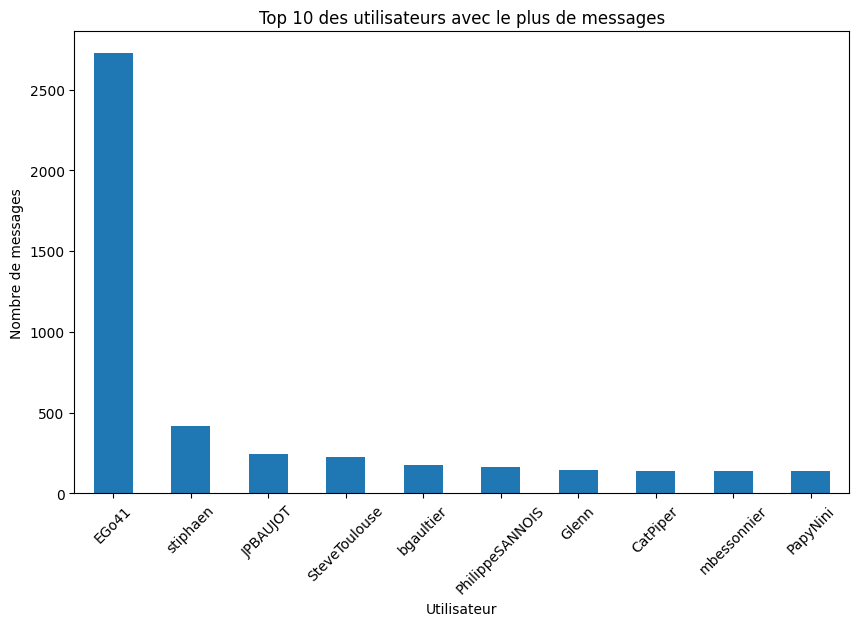

In [27]:
# Grouper par username et compter le nombre de messages, puis trier par ordre décroissant et prendre les 10 premiers
top_10_utilisateurs = df_IsEval['username'].value_counts().head(10)

# Créer le graphique
plt.figure(figsize=(10, 6))
top_10_utilisateurs.plot(kind='bar')
plt.title('Top 10 des utilisateurs avec le plus de messages')
plt.xlabel('Utilisateur')
plt.ylabel('Nombre de messages')
plt.xticks(rotation=45)
plt.show()

In [28]:
df_IsEval.columns
# Suppression des colonnes inutiles
df_IsEval_User = df_IsEval

df_IsEval_User.drop(['message_id', 'parent_id', 'thread_id', 'thread_type', 'title', 'context', 'courseware_title', 'body', 'type', 'created_at', 'updated_at', 'vote_down_count', 'vote_up_count', 'vote_point', 'vote_count', 'IsEval'], axis=1, inplace=True)


In [29]:
df_IsEval_User

# Filtrer les données où la valeur de la target n'est pas None
df_IsEval_User = df_IsEval_User[df_IsEval_User['grade'].notna()]

In [30]:
# Fonction pour extraire les informations
def extract_info(course_id):
    # Regex pour chaque format avec limite de 5 caractères pour le cours
    regex1 = r'^(.*?)/(.*?)(?:S.*?)?/(.*?)$'
    regex2 = r'^course-v1:(.*?)\+(.*?)(?:S.*?)?\+(.*?)$'

    # Vérifier et extraire les informations pour le premier format
    match1 = re.match(regex1, course_id)
    if match1:
        return match1.groups()

    # Vérifier et extraire les informations pour le deuxième format
    match2 = re.match(regex2, course_id)
    if match2:
        return match2.groups()

    # Retourner None si aucun format ne correspond
    return None, None, None

# Appliquer la fonction aux données
df_IsEval_User[['université', 'cours', 'session']] = df_IsEval_User['course_id'].apply(extract_info).apply(pd.Series)


C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\485004711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval_User[['université', 'cours', 'session']] = df_IsEval_User['course_id'].apply(extract_info).apply(pd.Series)
C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\485004711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval_User[['université', 'cours', 'session']] = df_IsEval_User['course_id'].apply(extract_info).apply(pd.Series)
C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\

In [31]:
df_IsEval_User

,course_id,username,id,city,country,gender,level_of_education,email,CSP,year_of_birth,...,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name,université,cours,session
20779,MinesTelecom/04017/session01,Djuz87,58d572a36d4d80c00f9c3f5a,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,...,honor,honor,2016-05-30-1427,0.93,N/A,None,None,MinesTelecom,04017,session01
20780,MinesTelecom/04017/session01,Togo,58d572ad6d4d80c00f9c437c,Mens,FR,m,b,goujon.groshens@orange.fr,"Cadre, sup",1963,...,honor,honor,2016-05-30-1427,0.98,N/A,None,None,MinesTelecom,04017,session01
20781,MinesTelecom/04017/session01,calvir,58d5728c6d4d80c00f9c358b,None,,m,hs,virgile.calvert@imbe.fr,Prof interm,1976,...,honor,honor,2016-05-30-1427,1.0,N/A,None,None,MinesTelecom,04017,session01
20782,MinesTelecom/04017/session01,bgaultier,58d571846d4d80c00f9c244e,None,FR,m,m,b.gaultier@gmail.com,None,1986,...,honor,honor,2016-05-30-1427,0.56,N/A,None,None,MinesTelecom,04017,session01
20783,MinesTelecom/04017/session01,KRYSS38,58d572986d4d80c00f9c3ac1,None,,m,hs,None,Retraité,1954,...,N/A,honor,2016-05-30-1427,0.4,N/A,None,None,MinesTelecom,04017,session01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147685,course-v1:MinesTelecom+04026+session03,EGo41,58d571866d4d80c00f9c25e7,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,...,N/A,honor,None,0.07,N/A,None,EGtest,MinesTelecom,04026,session03
147684,course-v1:MinesTelecom+04026+session03,PERCE-NEIGE,58d576d06d4d80c00f9c7027,None,,f,,None,None,None,...,None,N/A,None,0.0,N,None,honor,MinesTelecom,04026,session03
148778,course-v1:MinesTelecom+04021+session05,EGo41,58d571866d4d80c00f9c25e7,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,...,N/A,honor,None,0.0,N/A,None,None,MinesTelecom,04021,session05
149295,course-v1:MinesTelecom+04021+session05,BERNEZET_Christian,5bc0d33e183c7550fd9aa100,None,None,None,None,None,None,None,...,N/A,honor,None,0.0,N/A,None,None,MinesTelecom,04021,session05


In [32]:
df_IsEval_User.drop(['course_id',"session" ],axis=1, inplace=True)

C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\1864737469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval_User.drop(['course_id',"session" ],axis=1, inplace=True)


In [33]:
df_IsEval_User.columns

Index(['username', 'id', 'city', 'country', 'gender', 'level_of_education',
       'email', 'CSP', 'year_of_birth', 'csp', 'idUser',
       'Certificate Delivered', 'Certificate Eligible', 'Certificate Type',
       'Enrollment Track', 'date_grade_report', 'grade', 'Verification Status',
       'date_problem_grade_report', 'Cohort Name', 'université', 'cours'],
      dtype='object')

In [34]:
df_IsEval_User.drop(['id',"username"],axis=1, inplace=True)

C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\555703225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval_User.drop(['id',"username"],axis=1, inplace=True)


In [35]:
df_certif_eligible  = df_IsEval_User[df_IsEval_User['Certificate Eligible'] == 'Y']
df_certif_delivered = df_IsEval_User[df_IsEval_User['Certificate Delivered'] == 'Y']

In [36]:
df_certif_eligible.sort_values(by='grade')

,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name,université,cours
72629,Grenoble,FR,m,m,None,None,1974,None,58d571bf6d4d80c00f9c313d,N,Y,N/A,honor,2017-04-12-2129mod,0.5,N/A,None,None,MinesTelecom,04018
74372,Paris,FR,m,m,None,"Cadre, sup",1970,None,58d5717f6d4d80c00f9c1dc5,N,Y,N/A,honor,2017-04-12-2129mod,0.5,N/A,None,None,MinesTelecom,04018
109483,None,FR,m,m,philippe@meslin.eu,"Cadre, sup",1964,None,58d5729e6d4d80c00f9c3d73,Y,Y,honor,honor,None,0.5,N/A,None,Default Group,MinesTelecom,04018
45394,EVRUNES,FR,m,hs,None,Ouvrier,1981,None,58d571836d4d80c00f9c22ee,N,Y,N/A,honor,2016-12-12-0855,0.5,N/A,None,None,MinesTelecom,04021
45543,EVRUNES,FR,m,hs,None,Ouvrier,1981,None,58d571836d4d80c00f9c22ee,N,Y,N/A,honor,2016-12-12-0855,0.5,N/A,None,None,MinesTelecom,04021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22907,Periana,ES,m,hs,chutetearer2013@gmail.com,Sans,1957,None,58d572b46d4d80c00f9c4610,Y,Y,honor,honor,2016-05-30-1427,1.0,N/A,None,None,MinesTelecom,04017
54977,paris,FR,m,m,None,Sans,1976,None,58d571866d4d80c00f9c25d2,Y,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017
54976,PARIS,FR,m,m,None,Enseignant,1978,None,58d5717d6d4d80c00f9c1acb,Y,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017
104629,None,None,f,None,None,Enseignant,None,None,58fef59188d1216b89e58669,N,Y,N/A,honor,None,1.0,N/A,None,Default Group,MinesTelecom,04021


In [37]:
df_certif_delivered.sort_values(by='grade')

,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name,université,cours
76984,None,None,None,None,None,None,None,None,592d87140d924cfc37f8e340,Y,N,verified,verified,None,0.24,ID Verified,None,None,CNAM,01002
76389,None,None,None,None,None,None,None,None,592d87140d924cfc37f8e348,Y,N,verified,verified,None,0.24,ID Verified,None,None,CNAM,01002
67955,None,None,None,None,None,None,None,None,592d87140d924cfc37f8e340,Y,N,verified,verified,None,0.24,ID Verified,None,None,CNAM,01002
57739,None,None,None,None,None,None,None,None,58e267eee8c4311b5150f007,Y,N,verified,verified,None,0.26,ID Verified,None,None,CNAM,01002
62917,None,None,None,None,None,None,None,None,58e267eee8c4311b5150f007,Y,N,verified,verified,None,0.26,ID Verified,None,None,CNAM,01002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97192,None,FR,m,m,None,"Cadre, sup",1953,None,58d5717d6d4d80c00f9c1b3c,Y,Y,honor,honor,None,1.0,N/A,None,Default Group,MinesTelecom,04017
55611,Metz,FR,m,other,None,Retraité,1945,None,58d571836d4d80c00f9c22b8,Y,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017
55574,Lyon,FR,m,el,None,Retraité,1949,None,58d571846d4d80c00f9c2398,Y,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017
55663,Metz,FR,m,other,None,Retraité,1945,None,58d571836d4d80c00f9c22b8,Y,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017


In [38]:
# Filtrer le DataFrame pour les utilisateurs qui sont éligibles et ont reçu un certificat
df_certif_eligible_and_delivered = df_IsEval_User[
    (df_IsEval_User['Certificate Eligible'] == 'Y') & 
    (df_IsEval_User['Certificate Delivered'] == 'Y')
]

In [39]:
df_certif_eligible_and_delivered.sort_values(by='grade')

,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,idUser,Certificate Delivered,Certificate Eligible,Certificate Type,Enrollment Track,date_grade_report,grade,Verification Status,date_problem_grade_report,Cohort Name,université,cours
109483,None,FR,m,m,philippe@meslin.eu,"Cadre, sup",1964,None,58d5729e6d4d80c00f9c3d73,Y,Y,honor,honor,None,0.5,N/A,None,Default Group,MinesTelecom,04018
27010,EYGUIERES,FR,m,m,olivier.morganti@gmail.com,None,1976,None,58d5728d6d4d80c00f9c3631,Y,Y,honor,honor,2016-07-20-1511,0.5,N/A,None,None,MinesTelecom,04018
29547,reims,FR,m,hs,xavier.nayrac@gmail.com,"Cadre, sup",1972,None,58d574016d4d80c00f9c5dbd,Y,Y,honor,honor,2016-07-20-1511,0.5,N/A,None,None,MinesTelecom,04018
21632,Orléans,FR,m,p,None,None,1984,None,58d5728e6d4d80c00f9c3678,Y,Y,honor,honor,2016-05-30-1427,0.51,N/A,None,None,MinesTelecom,04017
20861,TOULOUSE,FR,m,other,sami.ezzerouali@hotmail.com,None,1995,None,58d5729c6d4d80c00f9c3c8e,Y,Y,honor,honor,2016-05-30-1427,0.51,N/A,None,None,MinesTelecom,04017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25212,Limours,FR,,m,chugonet.pro@gmail.com,"Cadre, sup",None,None,58d572dc6d4d80c00f9c5254,Y,Y,honor,honor,2016-07-20-1511,1.0,N/A,None,None,MinesTelecom,04018
25205,Auxonne,FR,m,none,o.cretey@cia-informatique.com,Prof interm,1958,None,58d572966d4d80c00f9c3a24,Y,Y,honor,honor,2016-07-20-1511,1.0,N/A,None,None,MinesTelecom,04018
25203,Echirolles,FR,m,m,luc@luc-laurens.com,"Cadre, sup",1965,None,58d572a96d4d80c00f9c4188,Y,Y,honor,honor,2016-07-20-1511,1.0,N/A,None,None,MinesTelecom,04018
63461,Liège,BE,m,jhs,None,Sans,1963,None,58d571876d4d80c00f9c275d,Y,Y,honor,honor,2017-03-29-2201,1.0,N/A,2017-03-11-1848,None,MinesTelecom,04017


In [40]:
nombre_cours1 = df_certif_eligible['cours'].nunique()
print(nombre_cours1)
nombre_cours2 = df_certif_delivered['cours'].nunique()
print(nombre_cours2)
nombre_cours3 = df_certif_eligible_and_delivered['cours'].nunique()
print(nombre_cours3)

5
5
5


In [41]:
df_cnam_delivered = df_certif_delivered[df_certif_delivered['université'] == 'CNAM']
df_cnam_eligible  = df_certif_eligible[df_certif_eligible['université'] == 'CNAM']
df_cnam = df_IsEval_User[df_IsEval_User['université'] == 'CNAM']

In [43]:
df_cnam_eligible.sort_values(by='grade').nunique()

city                          16
country                        7
gender                         3
level_of_education             6
email                          4
CSP                            3
year_of_birth                 14
csp                            0
idUser                       345
Certificate Delivered          1
Certificate Eligible           1
Certificate Type               2
Enrollment Track               2
date_grade_report              0
grade                         43
Verification Status            3
date_problem_grade_report      0
Cohort Name                    0
université                     1
cours                          1
dtype: int64

In [44]:
df_cnam_delivered.sort_values(by='grade').nunique()

city                          16
country                        7
gender                         3
level_of_education             6
email                          4
CSP                            3
year_of_birth                 14
csp                            0
idUser                       348
Certificate Delivered          1
Certificate Eligible           2
Certificate Type               2
Enrollment Track               2
date_grade_report              0
grade                         45
Verification Status            3
date_problem_grade_report      0
Cohort Name                    0
université                     1
cours                          1
dtype: int64

In [45]:
df_IsEval_grade = df_IsEval_User.drop(['Certificate Delivered',"idUser","Certificate Eligible","Verification Status","Cohort Name","idUser"],axis=1, inplace=True)

C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\3482617316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval_grade = df_IsEval_User.drop(['Certificate Delivered',"idUser","Certificate Eligible","Verification Status","Cohort Name","idUser"],axis=1, inplace=True)


In [46]:
# Ajouter la colonne isEmail
df_IsEval_User['isEmail'] = df_IsEval_User['email'].notna() & (df_IsEval_User['email'] != '')

C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\3062506104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval_User['isEmail'] = df_IsEval_User['email'].notna() & (df_IsEval_User['email'] != '')


In [47]:
columns_of_interest = ['city', 'country', 'gender', 'level_of_education', 'email', 'CSP', 'year_of_birth']
df_IsEval_User['datagiven'] = df_IsEval_User[columns_of_interest].notna().sum(axis=1)

C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\2127115038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval_User['datagiven'] = df_IsEval_User[columns_of_interest].notna().sum(axis=1)


In [48]:
df_IsEval_User

,city,country,gender,level_of_education,email,CSP,year_of_birth,csp,Certificate Type,Enrollment Track,date_grade_report,grade,date_problem_grade_report,université,cours,isEmail,datagiven
20779,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,None,honor,honor,2016-05-30-1427,0.93,None,MinesTelecom,04017,True,7
20780,Mens,FR,m,b,goujon.groshens@orange.fr,"Cadre, sup",1963,None,honor,honor,2016-05-30-1427,0.98,None,MinesTelecom,04017,True,7
20781,None,,m,hs,virgile.calvert@imbe.fr,Prof interm,1976,None,honor,honor,2016-05-30-1427,1.0,None,MinesTelecom,04017,True,7
20782,None,FR,m,m,b.gaultier@gmail.com,None,1986,None,honor,honor,2016-05-30-1427,0.56,None,MinesTelecom,04017,True,6
20783,None,,m,hs,None,Retraité,1954,None,N/A,honor,2016-05-30-1427,0.4,None,MinesTelecom,04017,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147685,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,N/A,honor,None,0.07,None,MinesTelecom,04026,True,7
147684,None,,f,,None,None,None,None,None,N/A,None,0.0,None,MinesTelecom,04026,False,4
148778,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,N/A,honor,None,0.0,None,MinesTelecom,04021,True,7
149295,None,None,None,None,None,None,None,None,N/A,honor,None,0.0,None,MinesTelecom,04021,False,0


In [49]:
df_IsEval_User.drop(["csp","Certificate Type","Enrollment Track"],axis=1, inplace=True)

C:\Users\RED94\AppData\Local\Temp\ipykernel_12364\3680086835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IsEval_User.drop(["csp","Certificate Type","Enrollment Track"],axis=1, inplace=True)


In [50]:
df_IsEval_User
df_IsEval_User_v2 = df_IsEval_User.drop(df_cnam.index)

In [51]:
duplicated_emails = df_IsEval_User_v2[df_IsEval_User_v2.duplicated(subset=['email','cours'], keep=False)]
email_not_none = duplicated_emails[duplicated_emails['email'].notna()]
date_none = email_not_none[email_not_none['date_grade_report'].isna()]

In [52]:
date_none

,city,country,gender,level_of_education,email,CSP,year_of_birth,date_grade_report,grade,date_problem_grade_report,université,cours,isEmail,datagiven
79189,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,0.42,None,MinesTelecom,04021,True,7
79191,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,0.42,None,MinesTelecom,04021,True,7
79203,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,0.42,None,MinesTelecom,04021,True,7
79372,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,0.42,None,MinesTelecom,04021,True,7
79622,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,0.42,None,MinesTelecom,04021,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145114,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,0.0,None,MinesTelecom,04021,True,7
145138,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,0.0,None,MinesTelecom,04021,True,7
145175,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,0.0,None,MinesTelecom,04021,True,7
147685,None,,m,m,emmanuel.goudot@gmail.com,"Cadre, sup",1966,None,0.07,None,MinesTelecom,04026,True,7


In [53]:
# Supprimer les lignes de df_IsEval_User présentes dans date_none
df_IsEval_User_cleaned_final = df_IsEval_User_v2.drop(date_none.index)

In [54]:
df_IsEval_User_cleaned_final

,city,country,gender,level_of_education,email,CSP,year_of_birth,date_grade_report,grade,date_problem_grade_report,université,cours,isEmail,datagiven
20779,Limoges,FR,m,hs,djuz87@gmail.com,Employé,1968,2016-05-30-1427,0.93,None,MinesTelecom,04017,True,7
20780,Mens,FR,m,b,goujon.groshens@orange.fr,"Cadre, sup",1963,2016-05-30-1427,0.98,None,MinesTelecom,04017,True,7
20781,None,,m,hs,virgile.calvert@imbe.fr,Prof interm,1976,2016-05-30-1427,1.0,None,MinesTelecom,04017,True,7
20782,None,FR,m,m,b.gaultier@gmail.com,None,1986,2016-05-30-1427,0.56,None,MinesTelecom,04017,True,6
20783,None,,m,hs,None,Retraité,1954,2016-05-30-1427,0.4,None,MinesTelecom,04017,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146195,None,None,None,None,None,None,None,None,0.0,None,MinesTelecom,04021,False,0
146287,Namur,BE,m,b,miguipda@gmail.com,Employé,None,None,0.0,None,MinesTelecom,04021,True,6
147684,None,,f,,None,None,None,None,0.0,None,MinesTelecom,04026,False,4
149295,None,None,None,None,None,None,None,None,0.0,None,MinesTelecom,04021,False,0


In [55]:
df_final_test = df_IsEval_User_cleaned_final.drop(columns=['email','date_grade_report','date_grade_report','date_problem_grade_report','université'],axis = 1)

In [56]:
df_final_test

,city,country,gender,level_of_education,CSP,year_of_birth,grade,cours,isEmail,datagiven
20779,Limoges,FR,m,hs,Employé,1968,0.93,04017,True,7
20780,Mens,FR,m,b,"Cadre, sup",1963,0.98,04017,True,7
20781,None,,m,hs,Prof interm,1976,1.0,04017,True,7
20782,None,FR,m,m,None,1986,0.56,04017,True,6
20783,None,,m,hs,Retraité,1954,0.4,04017,False,6
...,...,...,...,...,...,...,...,...,...,...
146195,None,None,None,None,None,None,0.0,04021,False,0
146287,Namur,BE,m,b,Employé,None,0.0,04021,True,6
147684,None,,f,,None,None,0.0,04026,False,4
149295,None,None,None,None,None,None,0.0,04021,False,0


In [57]:
# Obtenir les valeurs uniques de la colonne 'colonne'
csp = df_final_test['CSP'].unique()
educ = df_final_test['level_of_education'].unique()

In [58]:
csp

array(['Employé', 'Cadre, sup', 'Prof interm', None, 'Retraité',
       'Etudiant', 'Enseignant', 'Recherche emploi', 'Sans',
       "Artisan, commerçant ou chef d\\'entreprise", 'Ouvrier',
       "Artisan, commerçant ou chef d'entreprise"], dtype=object)

In [59]:
educ

array(['hs', 'b', 'm', 'p', 'other', 'jhs', '', 'none', 'a', 'el', 'None',
       None], dtype=object)

In [122]:

# Créer une copie de l'ensemble de données
df_encoded = df_final_test.copy()

# Encoder les colonnes catégorielles 'level_of_education', 'CSP', 'country' et 'gender'
label_encoders = {}
for column in ['level_of_education', 'CSP', 'country', 'gender']:
    encoder = LabelEncoder()
    df_encoded[column + '_encoded'] = encoder.fit_transform(df_encoded[column])
    label_encoders[column] = encoder


# Sélectionner les caractéristiques et la cible
X = df_encoded.drop(columns=['grade', 'city', 'year_of_birth', 'cours', 'level_of_education', 'CSP', 'country', 'gender', 'isEmail'])
y = df_encoded['grade']

# Division des données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 0.23894691449441063
MSE: 0.10917309477703356
RMSE: 0.3304135208750295
R^2: 0.03975066660189153


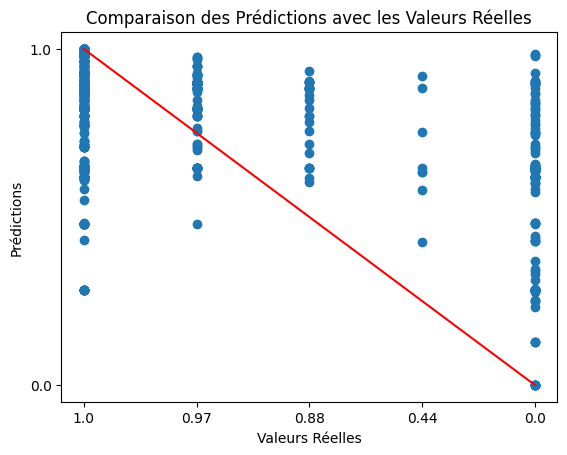

In [113]:
# Comparaison des prédictions avec les valeurs réelles
plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des Prédictions avec les Valeurs Réelles')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Ligne y=x
plt.show()

In [114]:
from sklearn.model_selection import cross_val_score

# Validation croisée avec 5 folds
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mean_cv_score = -cv_scores.mean()

print(f"Mean Cross-Validated MAE: {mean_cv_score}")

Mean Cross-Validated MAE: 0.27215403150227274


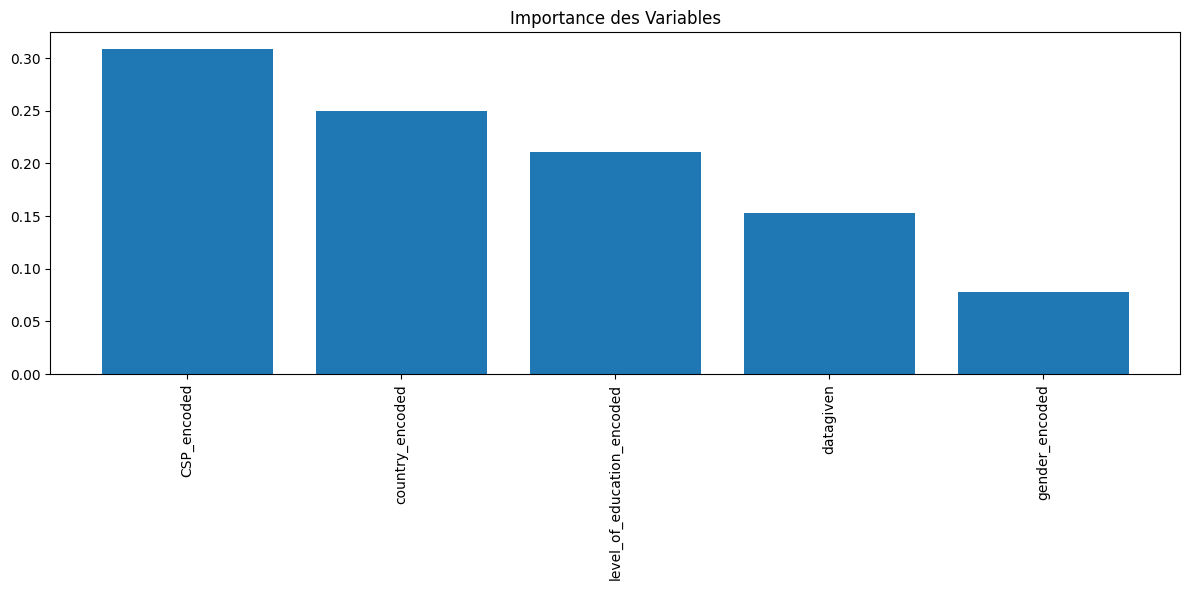

In [87]:
import numpy as np

# Importance des variables
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Visualisation de l'importance des variables
plt.figure(figsize=(12, 6))
plt.title("Importance des Variables")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [111]:
# Pour prédire le grade pour de nouvelles données
def predict_grade(new_data, model, encoders):
    new_data_encoded = new_data.copy()
    for column in ['level_of_education', 'CSP', 'country', 'gender']:
        new_data_encoded[column + '_encoded'] = encoders[column].transform(new_data_encoded[column])
    X_new = new_data_encoded.drop(columns=['city', 'year_of_birth', 'cours', 'level_of_education', 'CSP', 'country', 'gender'])
    return model.predict(X_new)

# Exemple de nouvelles données
new_data = pd.DataFrame({
    'country': ['FR'],
    'gender': ['f'],
    'level_of_education': ['hs'],
    'CSP': ['Cadre, sup'],
    'year_of_birth' : [1980],
    'city' : ['Paris'],
    'cours' : ['04021'],
    'datagiven' : [7]
})

# Prédire le grade pour les nouvelles données
predicted_grade = predict_grade(new_data, model, label_encoders)
print(f"Predicted grade: {predicted_grade}")

Predicted grade: [0.66271271]
